## 1) Importing Libraries and Loading the Dataset

In [1]:
# Importing Libraries:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew, chi2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import missingno as ms

In [2]:
# Loading Data:
df_raw = pd.read_csv("dataset.csv", dtype={"pdes":"str", 
                                           "name":"str",
                                           "prefix":"str"})

In [3]:
# Making a copy of the dataset:
df = df_raw.copy()

## 2) Data Cleaning

In [4]:
# Information about the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox         958524 non-null  object 
 17  e         

In [5]:
# Deleting some useless columns:
df.drop(columns=["prefix", "name", "spkid", "orbit_id", 'pdes'], inplace=True)
print(f"Shape: {df.shape}")

Shape: (958524, 40)


 - RMS column

  After searching a lot about this columns, I could not find anthing about it, so as I am no keen on it, I will drop it as well.

In [6]:
# Deleting rms column:
df.drop(columns=['rms'], inplace=True)

Let's see the columns that I want to set as index.

In [7]:
# Unique values of the full_name column: 
df['full_name'].unique()

array(['     1 Ceres', '     2 Pallas', '     3 Juno', ...,
       '       (6344 P-L)', '       (2060 T-2)', '       (2678 T-3)'],
      dtype=object)

As we can see that at the beginning of the names, there are some blank spaces, so we need to fix it before set them as index.

In [8]:
# Removing the blank space in front of the names: 
df['full_name'] = df['full_name'].str.strip(" ")
df['full_name'].unique()

array(['1 Ceres', '2 Pallas', '3 Juno', ..., '(6344 P-L)', '(2060 T-2)',
       '(2678 T-3)'], dtype=object)

In [9]:
# Setting ID  and Full_name as a multindex:
df.set_index(["id", "full_name"], inplace=True)

- Moid and Moid_ld columns

Both of them measure distances, and the difference between them is that the first one measures distance in astronomical units, which means it measures distance based on the distance between the Earth and the Sun. On the other hand, the second attribute measures the distance using a unit called lunar distance, which has a very objective description and is easy to interpret.

In [10]:
# Correlation between moid and moid_ld
df[['moid', 'moid_ld']].corr()

,moid,moid_ld
moid,1.0,1.0
moid_ld,1.0,1.0


As we can expect, they are highly correlated, so we can choose one of them to represent the information about distance. With this in mind, we will drop the moid_ld column because its range is much larger than that of the moid column.

In [11]:
# Dropping the moid_ld column:
df.drop(columns=['moid_ld'], inplace=True)

 - tp and tp_cal columns

Accondingly to the  Nasa website https://ssd.jpl.nasa.gov/tools/sbdb_query.html#!#results, both of these columns have the same name "Time of the Perihelion Passage (TDB)". Furthermore, the first attribute represents the perihelion value itself and the second attribute can be a calibrated version of the tp variable. These attributes carry information about the time, which an asteroid, orbiting the Sun, is closest to it. These columns are presented in Unix Timestamp.

In [12]:
# Displaying the corelation of tp and tp_cal:
display(df[['tp', 'tp_cal']].corr())

,tp,tp_cal
tp,1.000000,0.998251
tp_cal,0.998251,1.000000


As we can see above, they are hightly correlated but I will not drop any of them for instance, because I want to explore them more on the next topic of the project.

In [13]:
# Looking at the first five rows:
df.head()

,,neo,pha,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,equinox,...,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class
id,full_name,,,,,,,,,,,,,,,,,,,,,
a0000001,1 Ceres,N,N,3.40,939.400,0.0900,0.200,2458600.5,58600,20190427.0,J2000,...,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA
a0000002,2 Pallas,N,N,4.20,545.000,0.1010,18.000,2459000.5,59000,20200531.0,J2000,...,8.832200e-08,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA
a0000003,3 Juno,N,N,5.33,246.596,0.2140,10.594,2459000.5,59000,20200531.0,J2000,...,8.139200e-08,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA
a0000004,4 Vesta,N,N,3.00,525.400,0.4228,0.200,2458600.5,58600,20190427.0,J2000,...,1.928600e-09,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA
a0000005,5 Astraea,N,N,6.90,106.699,0.2740,3.140,2459000.5,59000,20200531.0,J2000,...,6.092400e-08,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA


Missing Data

In [14]:
# Looking for missing data:
df.isna().sum().sort_values(ascending=False).to_frame()

,0
albedo,823421
diameter_sigma,822443
diameter,822315
sigma_per,19926
sigma_ad,19926
sigma_w,19922
sigma_om,19922
sigma_a,19922
sigma_q,19922
sigma_i,19922


In [15]:
# Deleting columns that hava more than 50% of missing data:
df.dropna(thresh=0.5*len(df), axis=1, inplace=True)
print(f"Shape: {df.shape}")

Shape: (958524, 33)


In [16]:
# Looking for missing data:
df.isna().sum().sort_values(ascending=False)

sigma_per    19926
sigma_ad     19926
sigma_om     19922
sigma_e      19922
sigma_tp     19922
sigma_n      19922
sigma_ma     19922
sigma_w      19922
sigma_i      19922
sigma_q      19922
sigma_a      19922
moid         19921
pha          19921
H             6263
neo              4
ad               4
per              4
ma               1
per_y            1
tp               0
tp_cal           0
n                0
w                0
om               0
i                0
q                0
a                0
e                0
equinox          0
epoch_cal        0
epoch_mjd        0
epoch            0
class            0
dtype: int64

In [17]:
# Description of the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 958524 entries, ('a0000001', '1 Ceres') to ('bT3S2678', '(2678 T-3)')
Data columns (total 33 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   neo        958520 non-null  object 
 1   pha        938603 non-null  object 
 2   H          952261 non-null  float64
 3   epoch      958524 non-null  float64
 4   epoch_mjd  958524 non-null  int64  
 5   epoch_cal  958524 non-null  float64
 6   equinox    958524 non-null  object 
 7   e          958524 non-null  float64
 8   a          958524 non-null  float64
 9   q          958524 non-null  float64
 10  i          958524 non-null  float64
 11  om         958524 non-null  float64
 12  w          958524 non-null  float64
 13  ma         958523 non-null  float64
 14  ad         958520 non-null  float64
 15  n          958524 non-null  float64
 16  tp         958524 non-null  float64
 17  tp_cal     958524 non-null  float64
 18  per        958520 non-

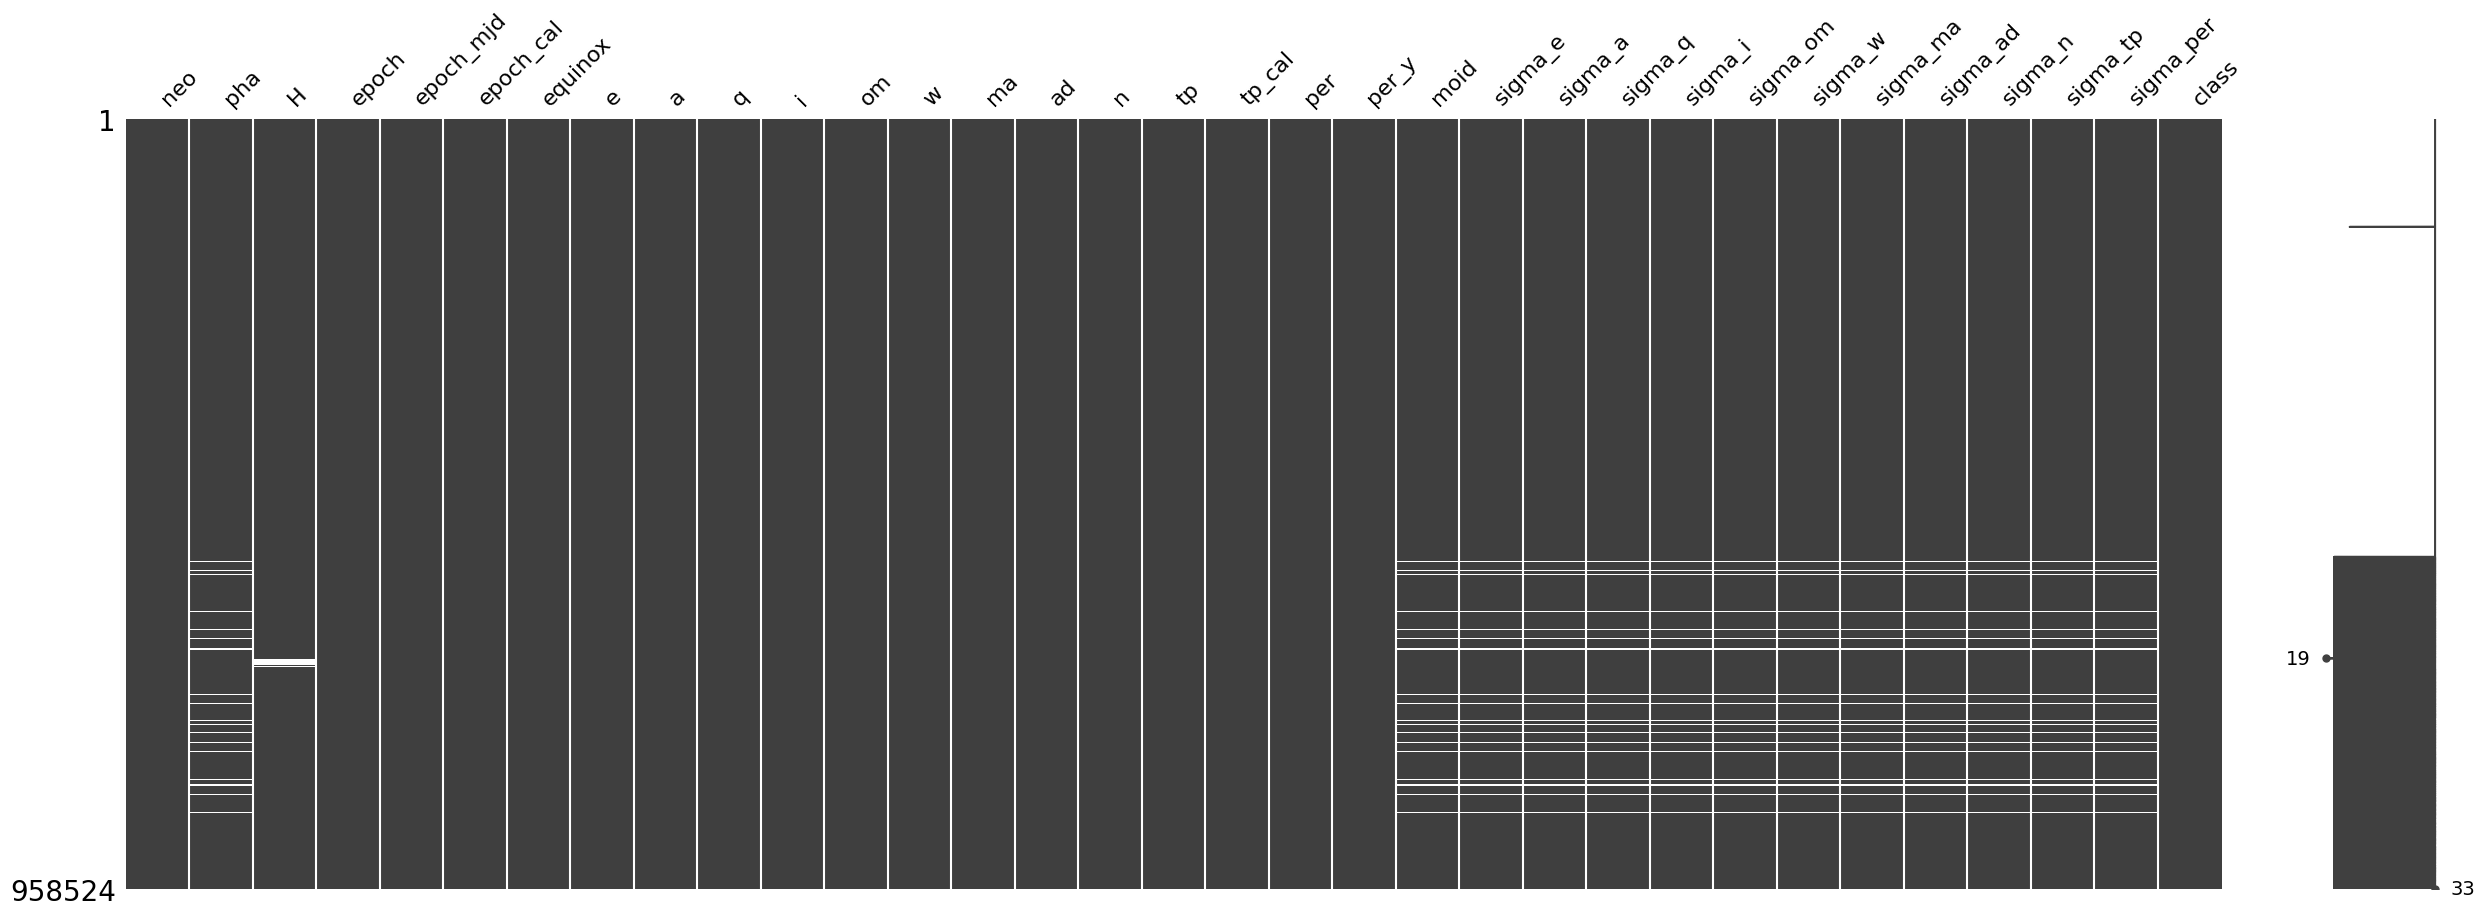

In [18]:
# Plottinhg the missing data matrix:
ms.matrix(df, figsize=(30, 10));

Apparently all the missing data in the *sigma* columns and in the *moid* column are related to the missing data contained in the Target column *pha*. 

In [19]:
# Looking at the missing data of the sigma columns:
df_2 = df[["pha", "moid", "sigma_e", "sigma_a", 
    "sigma_q", "sigma_i", "sigma_om", 
    "sigma_w", "sigma_ma", "sigma_ad",
    "sigma_n", "sigma_tp", "sigma_per"]]

df_2[df["pha"].isnull()]

,,pha,moid,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per
id,full_name,,,,,,,,,,,,,
bJ39R00R,(1939 RR),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bJ90O05K,(1990 OK5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bJ91R28N,(1991 RN28),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bJ93T11C,(1993 TC11),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bJ94A09F,(1994 AF9),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bK20K03Q,(2020 KQ3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bK20K03R,(2020 KR3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bK20K03V,(2020 KV3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see above, 19921 from 19922 forom the missing data is related to the target column. Since we do not have data of the dependent variable for those obsrvations, we can drop all of them basend on the target.

In [20]:
# Dropping observations with missing data in the dependent variable:
df.dropna(subset="pha", inplace=True)
df.isna().sum().sort_values(ascending=False).to_frame()

,0
H,6262
sigma_per,5
sigma_ad,5
neo,4
ad,4
per,4
sigma_q,1
sigma_e,1
ma,1
sigma_a,1


Let's look at the missing data of the Absolute magnitude parameter. 

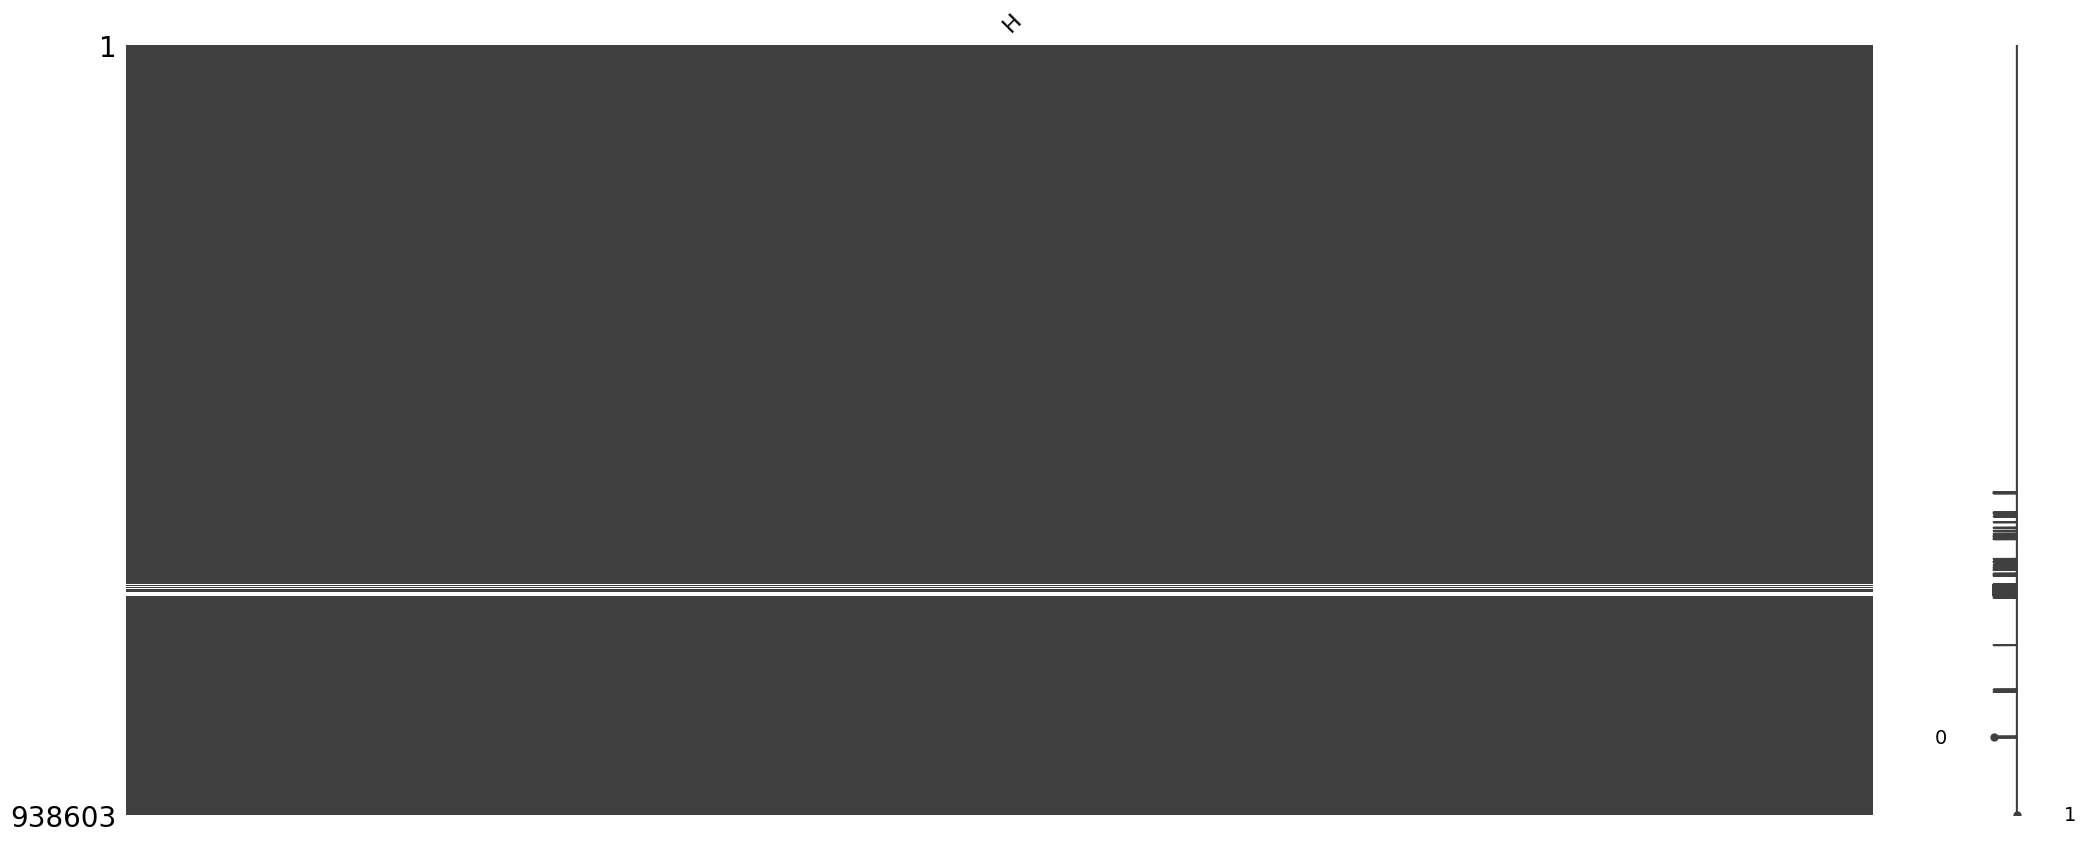

In [21]:
# Plotting the missing data matrix:
ms.matrix(df[['H']]);

Apparently, the missing data of the  H columns is not completely at random. So, we are going to imput them with the mean.

In [22]:
# Separete into two sets of data:
features = df.drop(columns='pha')
target = df['pha']

# Splitting the data:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Imputation of the missing data with the mean:
simpler_imputer = SimpleImputer(strategy='mean')
X_train['H'] = simpler_imputer.fit_transform(X_train[['H']])
X_test['H'] = simpler_imputer.transform(X_test[['H']])

For the rest of the missing data, we will drop them, because they were not systematically generated and because the number of missing data is not relevant compared with the amount of not missing data that we have.

In [23]:
# Dropping observations with missing data:
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

- Equinox variable.

In [24]:
# Looking at the unique data of equinox column:
df['equinox'].unique()

array(['J2000'], dtype=object)

Equinox variable has just 1 type of data, so it is not important for the analysis.

In [25]:
# Dropping equinox column:
X_train.drop(columns=['equinox'], inplace=True)
X_test.drop(columns=['equinox'], inplace=True)

In [26]:
# Shape of the sets:
print(f"Traning Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")

Traning Shape: (750877, 31)
Test Shape: (187720, 31)


## 3) Exploratory Data Analysis

Some usefull functions.

In [27]:
# Function that calculates kurtosis and skewness of a dataset:
def kurtosis_skewness(dataset: any):
    col = ["Kurtosis", "Skewness"]
    results = pd.DataFrame(index=dataset.describe().columns, columns=col)
    for c in dataset.describe().columns:
        kurt = kurtosis(dataset[c])
        skewness = skew(dataset[c])
        results.loc[c] = [kurt, skewness]

    return results


# Heatmap of correlations:
def heatmap_cor(df: any):
    correlation = df.coRr()
    mask = np.zeros_like(correlation)
    mask[np.triu_indices_from(correlation)] = True
    sns.heatmap(correlation, mask=mask, annot=True, c="crest", cbar=True)
    

### 3.1) Descriptive Statistics

Let's see the descriptive statistics of the sigma columns.

In [28]:
# Statistical Summary:
sigma_list = [i for i in  X_train.columns if 'sigma' in i]
X_train[sigma_list].describe()

,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per
count,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05
mean,7.758346e-01,1.726028e+01,2.054308e+01,1.214982e+00,6.000012e+00,4.549929e+05,4.549157e+05,2.418465e+01,5.603977e-02,1.357960e+08,8.905039e+04
std,1.002947e+02,4.892992e+03,3.059394e+03,1.376154e+02,1.489532e+03,7.682747e+07,7.682117e+07,8.028341e+03,1.096641e+01,2.309041e+10,2.947131e+07
min,1.285600e-10,4.145500e-11,2.616800e-10,4.087800e-08,2.163900e-07,1.789300e-07,2.103800e-07,5.572900e-11,2.860900e-11,3.088400e-07,2.335200e-08
25%,5.477000e-08,2.046300e-08,1.462100e-07,6.094500e-06,3.622600e-05,5.759500e-05,2.573700e-05,2.340400e-08,2.768800e-09,1.110900e-04,1.793700e-05
50%,8.167200e-08,3.850300e-08,2.271700e-07,8.687700e-06,6.650600e-05,1.047800e-04,4.900800e-05,4.361800e-08,4.637100e-09,2.231400e-04,3.500700e-05
75%,2.338800e-07,1.044500e-07,6.595600e-07,1.591900e-05,1.613200e-04,3.118800e-04,1.719500e-04,1.196900e-07,1.125300e-08,8.145700e-04,9.779100e-05
max,3.942500e+04,3.241200e+06,1.015000e+06,5.533000e+04,1.199100e+06,3.340000e+10,3.339300e+10,5.509700e+06,7.698800e+03,1.041500e+13,1.910700e+10


Observations:

- All of the sigma columns are positive and have enormous ranges of values.
- All of the sigma columns have Outliers.
- Sigma_tp has the biggest standard deviantion and also the biggest max value.

Now let's dive a little bit into the Absolute magnitude parameter (H), epoch, epoch_mjd, epoch_cal, Eccentricity (e), Semi-major axis (a), Perihelion distance (q) and Inclination (i) columns.

In [29]:
# Selecting columns:
initial_columns = ['H', 'epoch', 'epoch_mjd', 'epoch_cal', 'e', 'a', 'q', 'i']

# Descriptive Statistic of the initial numeric columns:
X_train[initial_columns].describe()

,H,epoch,epoch_mjd,epoch_cal,e,a,q,i
count,750877.000000,7.508770e+05,750877.000000,7.508770e+05,750877.000000,750877.000000,750877.000000,750877.000000
mean,16.890408,2.458871e+06,58870.829587,2.019698e+07,0.156175,2.900448,2.397450,9.044674
std,1.795913,7.055785e+02,705.578515,1.940802e+04,0.092974,12.327240,2.157830,6.658707
min,-1.100000,2.425052e+06,25051.000000,1.927062e+07,0.000003,0.555418,0.075872,0.007744
25%,16.000000,2.459000e+06,59000.000000,2.020053e+07,0.092078,2.388185,1.971846,4.152227
50%,16.900000,2.459000e+06,59000.000000,2.020053e+07,0.144916,2.647204,2.226284,7.398350
75%,17.700000,2.459000e+06,59000.000000,2.020053e+07,0.200694,3.002401,2.579520,12.390983
max,33.200000,2.459000e+06,59000.000000,2.020053e+07,0.999591,8850.823836,80.398819,175.082901


Observations:

- Negative values in the Absolute magnitude parameter (H).
- There are some Outliers in Eccentricity (e), Semi-major axis (a), Perihelion distance (q), Inclination (i) and Absolute magnitude parameter (H).

Finally, let's see the rest of the numeric columns.

In [70]:
# Selecting columns:
other_columns = ['om', 'w', 'ma', 'ad', 'n', 'tp', 'tp_cal', 'per', 'per_y', 'moid']

# Descriptive Statistic of the other numeric columns: 
X_train[other_columns].describe()

,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid
count,750877.000000,750877.000000,750877.000000,750877.000000,750877.000000,7.508770e+05,7.508770e+05,7.508770e+05,750877.000000,7.508770e+05
mean,168.500688,181.376168,177.210988,3.403445,0.236686,2.458858e+06,2.019585e+07,2.900275e+03,7.940519,1.414834e+00
std,102.886239,103.885218,105.869845,24.216581,0.079762,1.600272e+03,4.391532e+04,3.635303e+05,995.291634,2.155184e+00
min,0.000025,0.000130,-67.136826,0.653773,0.000001,2.283183e+06,1.539011e+07,1.511918e+02,0.413941,4.544120e-07
25%,80.610134,91.541555,83.600824,2.781923,0.189453,2.458564e+06,2.019032e+07,1.348032e+03,3.690711,9.797690e-01
50%,159.947331,182.275912,175.284210,3.047334,0.228835,2.458946e+06,2.020041e+07,1.573184e+03,4.307143,1.240520e+00
75%,252.248318,271.571677,269.886957,3.365602,0.267056,2.459362e+06,2.021053e+07,1.900209e+03,5.202490,1.593080e+00
max,359.999793,359.998075,491.618014,17698.024949,2.381082,2.546362e+06,2.259081e+07,3.041403e+08,832690.763699,7.947660e+01


Observations:

- Longitude of the ascending node (om) , Argument of perihelium (w) have similar distributions.
- Mean Anomaly has negative values.
- The Earth Minimum Orbit Intersection Distance (moid) is 4.544120e-07 Astronomical Units.

### 3.2) Distributions

Now, let's look at the distribution and compute the Kurtosis and Skewness of the sigma columns. We will change the scale of the variables to a logarithmic scale due to their range, otherwise the plots won't look good and, we won't be able to interpret the results.

In [71]:
# Changing the scale of the data:
new_name = ['log_' + i for i in sigma_list]
dictionary = dict(zip(sigma_list, new_name))
log_data = np.log(X_train[sigma_list])
log_data.rename(columns=dictionary, inplace=True)

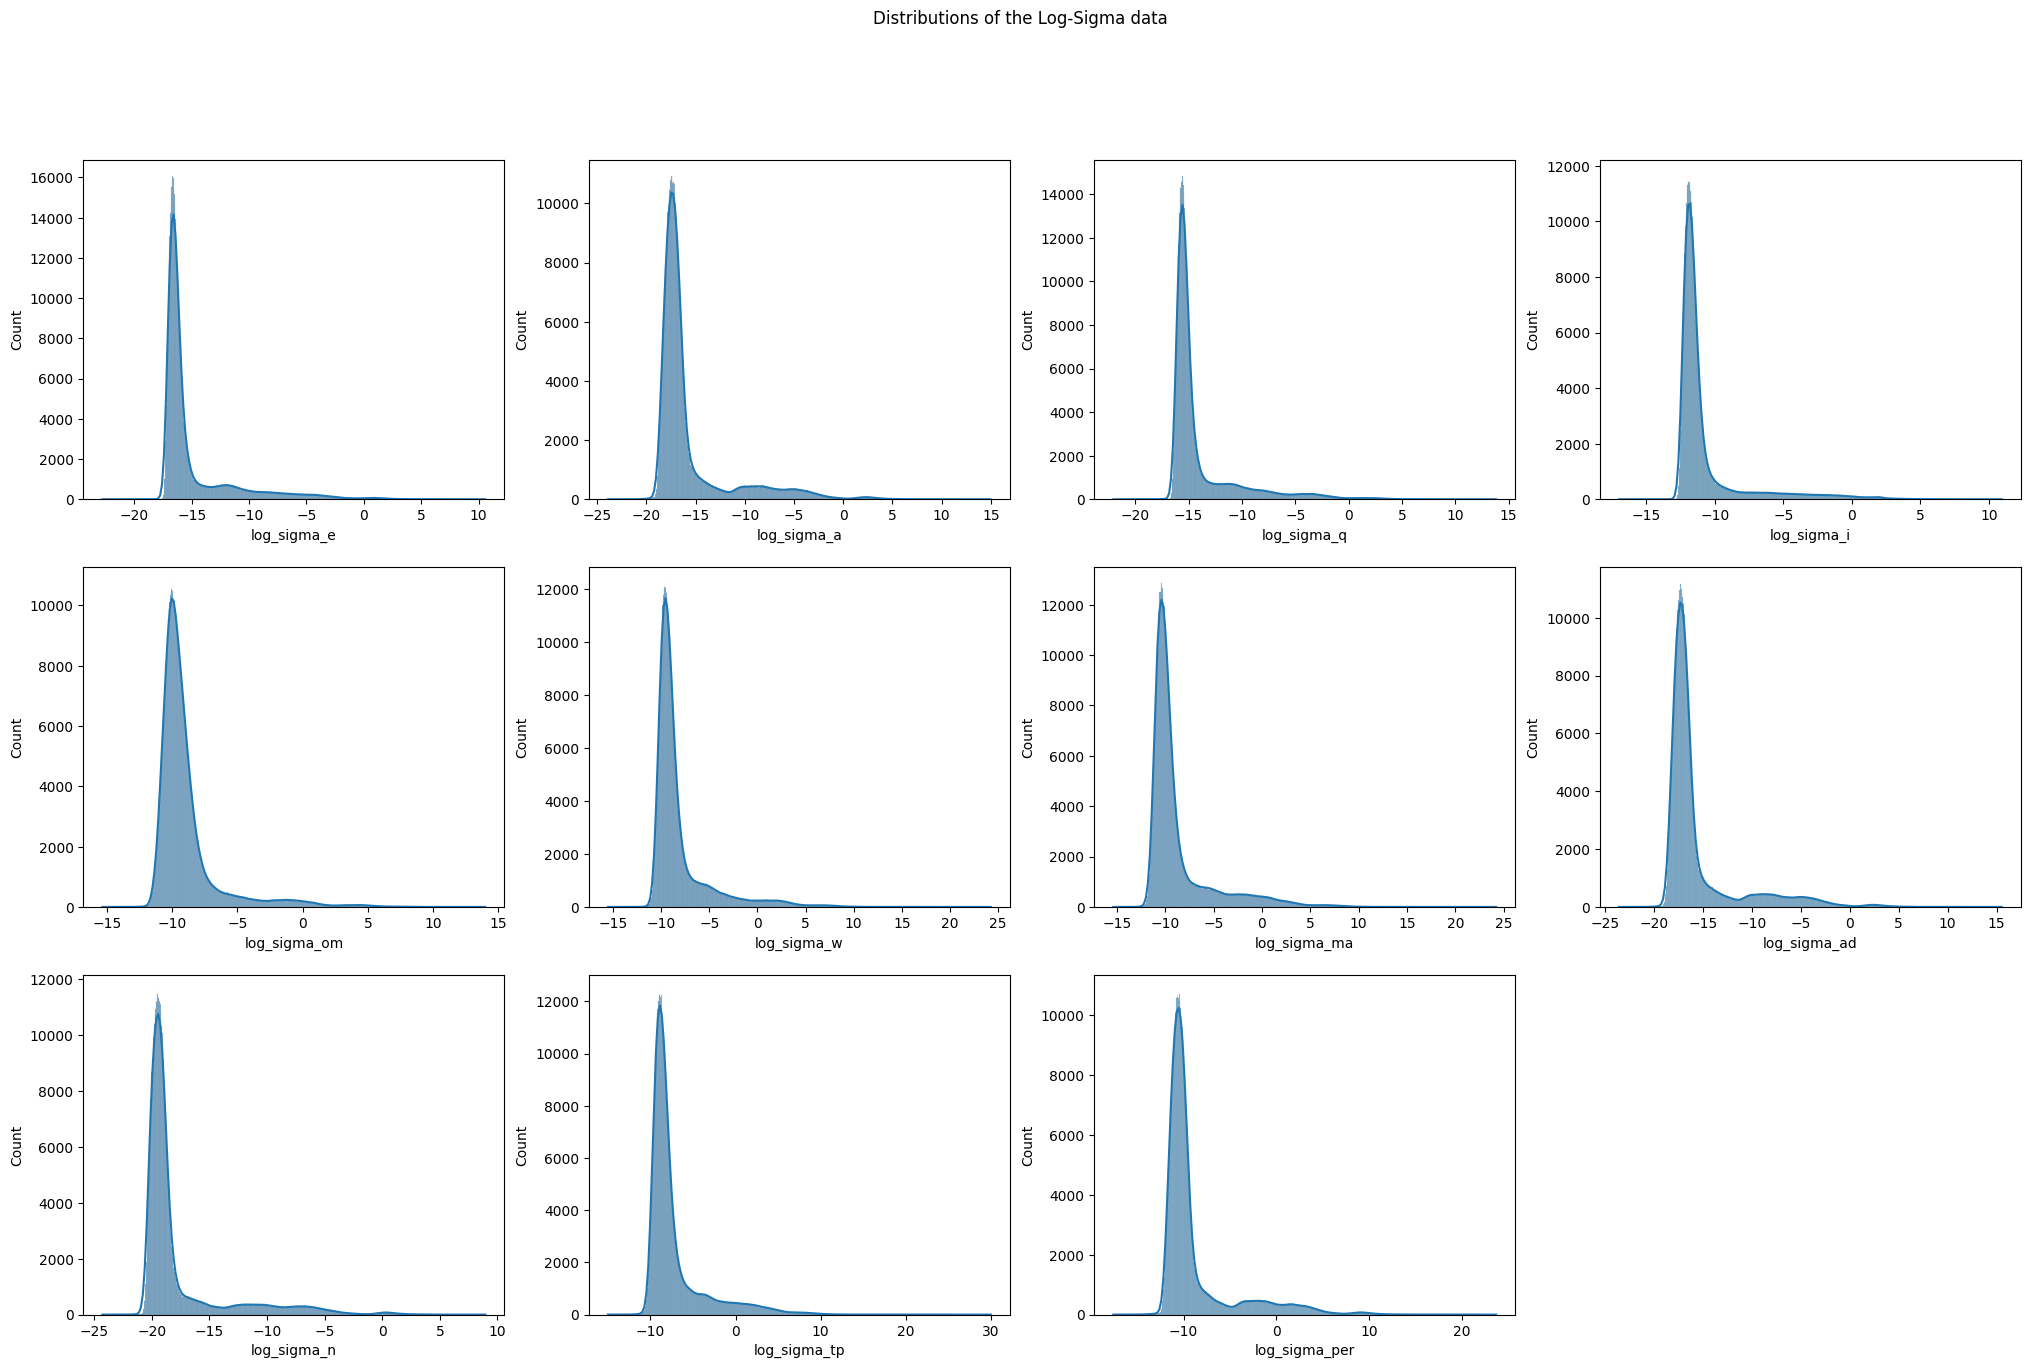

In [72]:
# Creating a subplot:
fig, ax = plt.subplots(nrows= 3, ncols=4, sharex=False, sharey=False, figsize=(25, 15))
fig.suptitle("Distributions of the Log-Sigma data")

# Histogram plots:
sns.histplot(log_data['log_sigma_e'], ax=ax[0, 0], kde=True)
sns.histplot(log_data['log_sigma_a'], ax=ax[0, 1], kde=True)
sns.histplot(log_data['log_sigma_q'], ax=ax[0, 2], kde=True)
sns.histplot(log_data['log_sigma_i'], ax=ax[0, 3], kde=True)
sns.histplot(log_data['log_sigma_om'], ax=ax[1, 0], kde=True)
sns.histplot(log_data['log_sigma_w'], ax=ax[1, 1], kde=True)
sns.histplot(log_data['log_sigma_ma'], ax=ax[1, 2], kde=True)
sns.histplot(log_data['log_sigma_ad'], ax=ax[1, 3], kde=True)
sns.histplot(log_data['log_sigma_n'], ax=ax[2, 0], kde=True)
sns.histplot(log_data['log_sigma_tp'], ax=ax[2, 1], kde=True)
sns.histplot(log_data['log_sigma_per'], ax=ax[2, 2], kde=True)

ax[2, 3].set_visible(False)

In [73]:
# Printing Kurtosis and Skewness for the log(sigma) columns:
kurtosis_skewness(log_data)

,Kurtosis,Skewness
log_sigma_e,6.204082,2.475314
log_sigma_a,5.646046,2.400785
log_sigma_q,6.867976,2.552479
log_sigma_i,8.351038,2.880583
log_sigma_om,10.566405,2.981978
log_sigma_w,8.715659,2.724005
log_sigma_ma,6.282922,2.400544
log_sigma_ad,5.587056,2.39486
log_sigma_n,5.49624,2.421342
log_sigma_tp,7.331019,2.48295


Observations:

- Log-Sigma features are hightly right skewed and definitely not follow normal distribution.
- All of the distributions are Leptokurtic because the Kurtosis is greater than three.

Let's see the distributions of Absolute magnitude parameter (H), epoch, epoch_mjd, epoch_cal, Eccentricity (e), Semi-major axis (a), Perihelion distance (q) and Inclination (i) columns.

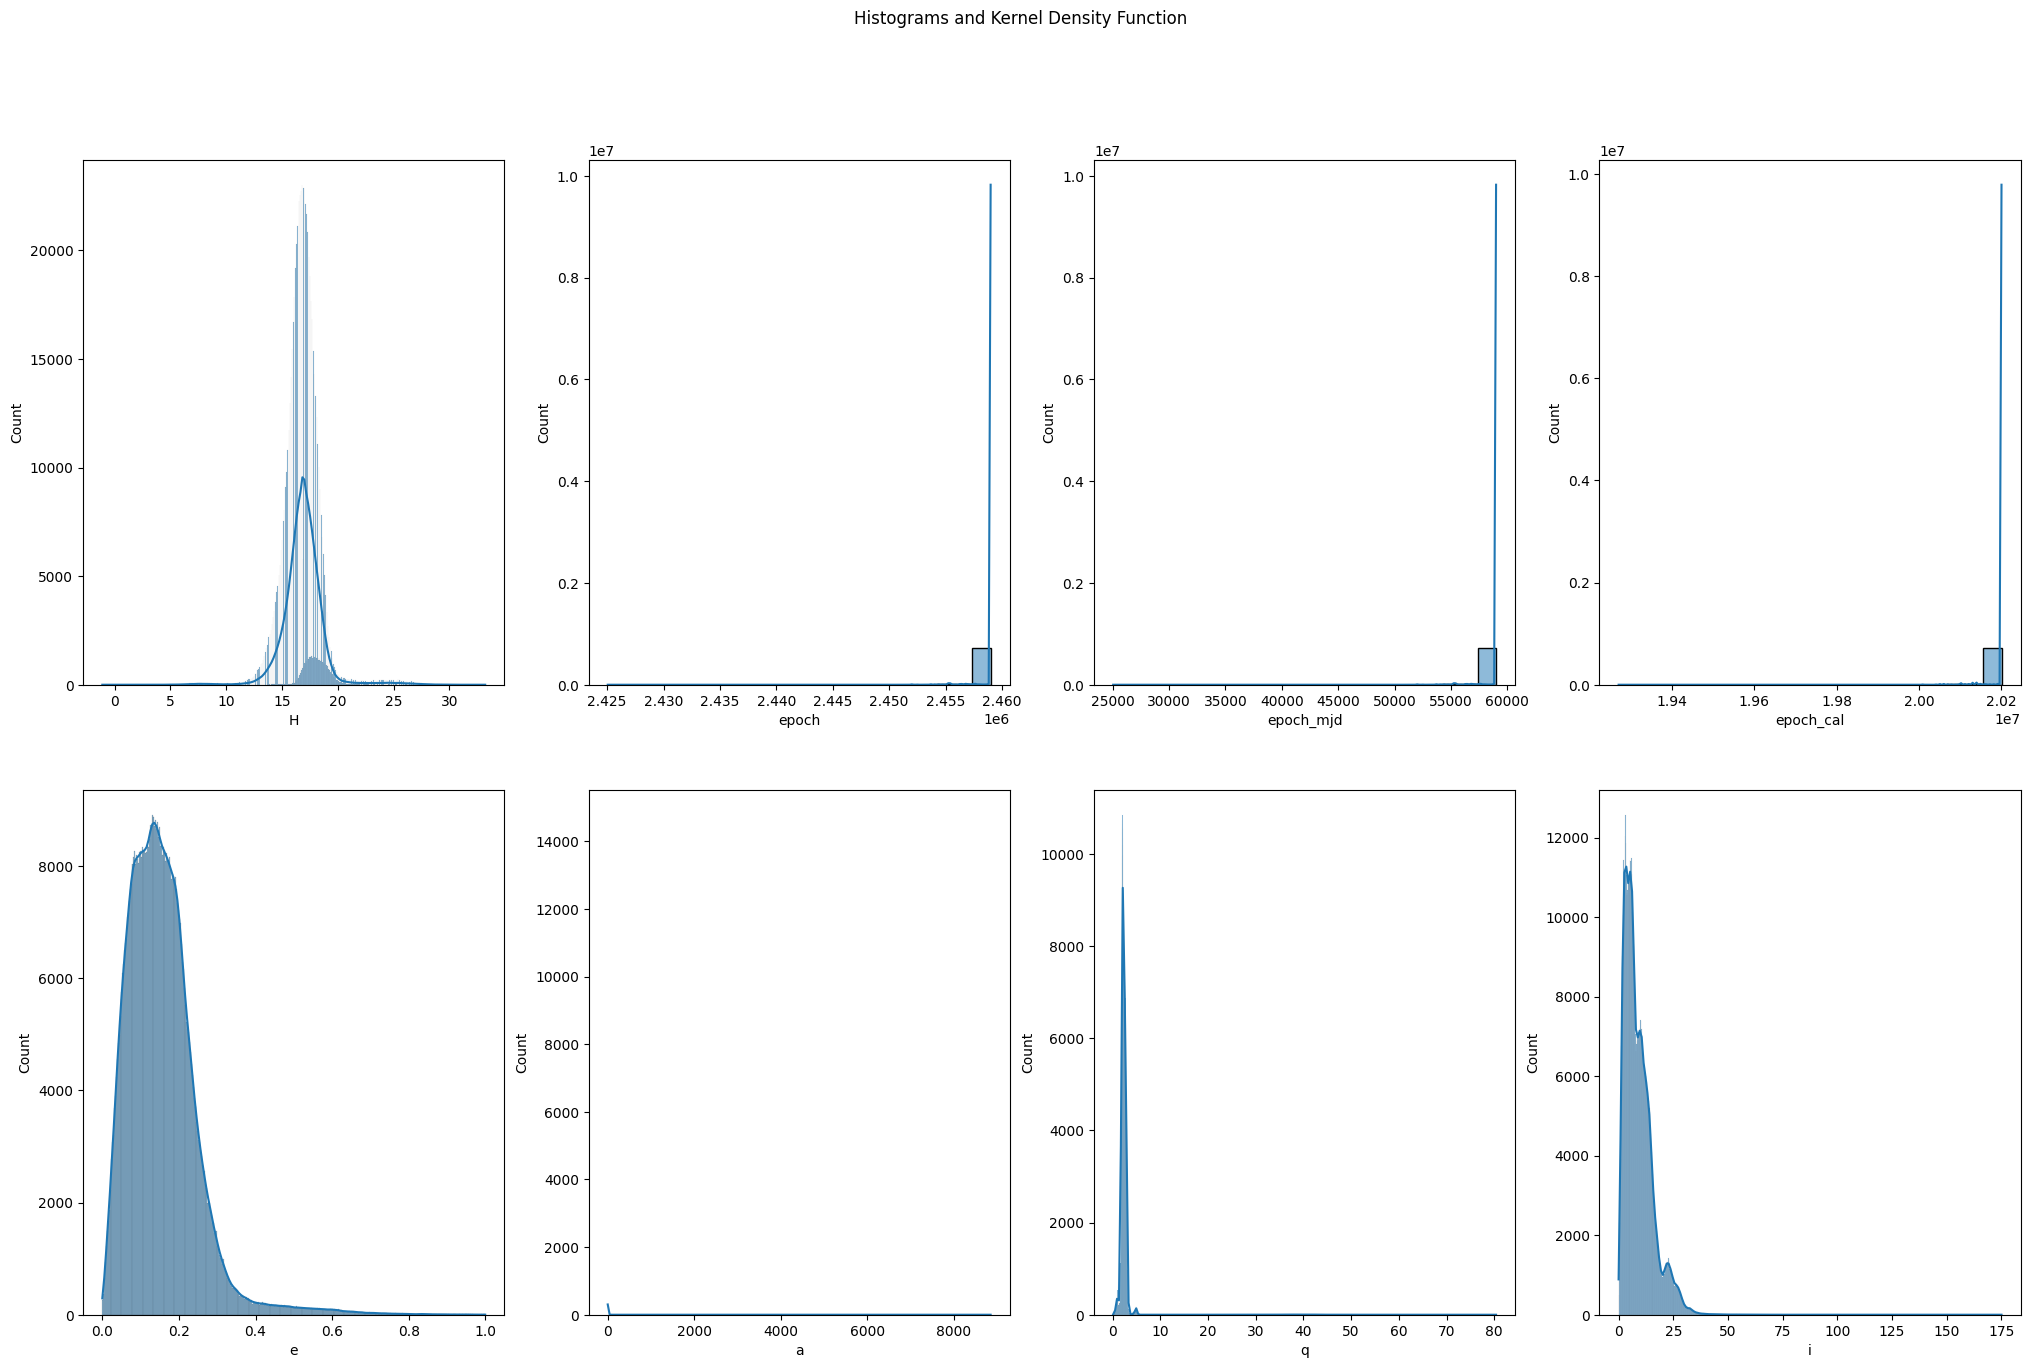

In [74]:
# Creating a subplot:
fig, ax = plt.subplots(nrows=2, ncols=4, sharex=False, sharey=False, figsize=(25, 15))
fig.suptitle("Histograms and Kernel Density Function")

# Histogram plots:
sns.histplot(X_train['H'], ax=ax[0, 0], kde=True)
sns.histplot(X_train['epoch'], ax=ax[0, 1], kde=True)
sns.histplot(X_train['epoch_mjd'], ax=ax[0, 2], kde=True)
sns.histplot(X_train['epoch_cal'], ax=ax[0, 3], kde=True)
sns.histplot(X_train['e'], ax=ax[1, 0], kde=True)
sns.histplot(X_train['a'], ax=ax[1, 1], kde=True)
sns.histplot(X_train['q'], ax=ax[1, 2], kde=True)
sns.histplot(X_train['i'], ax=ax[1, 3], kde=True);


In [75]:
# Printing Kurtosis and Skewness for the initial columns:
kurtosis_skewness(X_train[initial_columns])

,Kurtosis,Skewness
H,9.574231,0.632873
epoch,63.509785,-6.773483
epoch_mjd,63.509785,-6.773483
epoch_cal,63.507964,-6.778353
e,7.807368,1.900893
a,359883.099936,528.109344
q,264.636904,15.725018
i,22.503049,2.266021


Observations:

- 

In [76]:
# Creating a subplot:
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=False, sharey=False, figsize=(25, 15))
fig.suptitle("Histograms and Kernel Density Function")

# Histogram plots:
sns.histplot(X_train['om'], ax=ax[0, 0], kde=True)
sns.histplot(X_train['w'], ax=ax[0, 1], kde=True)
sns.histplot(X_train['ma'], ax=ax[0, 2], kde=True)
sns.histplot(X_train['ad'], ax=ax[0, 3], kde=True)
sns.histplot(X_train['n'], ax=ax[1, 0], kde=True)
#sns.histplot(X_train['tp'], ax=ax[1, 1], kde=True)
#sns.histplot(X_train['tp_cal'], ax=ax[1, 2], kde=True)
#sns.histplot(X_train['per'], ax=ax[1, 3], kde=True)
#sns.histplot(X_train['per_y'], ax=ax[2, 0], kde=True)
#sns.histplot(X_train['moid'], ax=ax[2, 1], kde=True)

ax[2, 2].set_visible(False)
ax[2, 3].set_visible(False);

In [ ]:
# Printing Kurtosis and Skewness for the other columns:
kurtosis_skewness(X_train[other_columns])

## 4) Preprocessing

## 5) Fine Tuning

## 6) Predictions